# Import statements

In [115]:
import numpy as np
from scipy.integrate import ode
import scipy
from matplotlib import pyplot as plt
from matplotlib import animation, rc
rc('animation', html='html5')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Point to top level directory on your own machine

In [116]:
import sys
sys.path.append('/home/hudson/Projects/SIOC 216/') #change this
from lib.params import *
from lib.moving_average import *
from lib.utils import *

# Model

Agent/interaction equations

In [117]:
def model(t, y, forces):
    #scipy solver takes input as a single vector.
    # We want to handle as two vectors so we split y in half
    n = int(len(y) / 2)
    x = y[:n]
    v = y[n:]
    
    #Passed forces
    I = forces['I'] 
    F = forces['F']
    noise = forces['noise']
    
    #Differential equation part
    dxdt = v
    dvdt = -k*x -c*v + np.tanh(I) + np.dot(Wf,F) + noise
    #dvdt = -k*x -c*v + I/np.sqrt(N) + np.dot(Wf,F) + noise
    
    #Since we split y in half we have to concatenate dxdt and dvdt 
    # into single vector
    f = np.array([dxdt, dvdt]).flatten()
    return(f)

External forcing equation

In [118]:
def F(t):
    if t < 100 and t > 98:
        return 1
    else: 
        return 0

# Model parameters

Time constant

In [119]:
dt = .1
tau = (1 // dt) * 20

Spring/damping constants

In [120]:
k = .25 #Spring constant
eta = 1 #+ np.random.randn(N) * np.sqrt(.1) #Damping ratio
c = eta * 2 * np.sqrt(k) #Damping coefficient

## Agent parameters

In [121]:
N = 3
a = genA(N)
b = genB(N)
alpha = genAlpha(N)
beta = genBeta(N)

#FILLER SINCE WE FORGOT TO DEFINE THE DISTRIBUTION 
c_star = np.ones((N,N)) * np.inf

In [122]:
a

array([-1.03190859,  1.18687758,  0.66076934])

In [123]:
b

array([-0.72695512,  0.60883682, -0.93625211])

In [124]:
alpha

array([ 1.11589659,  0.63149525,  1.35790812])

In [125]:
beta

array([ 0.96059329,  1.19886249,  0.72778094])

In [126]:
c_star

array([[ inf,  inf,  inf],
       [ inf,  inf,  inf],
       [ inf,  inf,  inf]])

## Connectivity parameters

Boolean agant-agent connection

In [127]:
# Q = np.ones((N,N)) #fully connected, for now
Q = scipy.sparse.random(N, N, .8) 
Q.data[:] = 1
Q = Q.A

#set diagonal to zero
for i in range(N):
    Q[i,i] = 0

External forcing connectivity

In [128]:
Wf = np.zeros(N)
Wf[0] = 1
#Wf = np.ones(N)
#Wf = np.random.randn(N)

## Initial conditions

In [129]:
y0 = 1*np.random.randn(2*N)# np.zeros(2*N) 

# Solver

In [130]:
#time
tstop = 200

# Set up ode solver
solver = ode(model)
solver.set_initial_value(y0)

#Loop through ode solver and get values as you go
t = [0]
y = [y0]

WIJ = []

# For updating forces
forces = {}

#solver.successful ensures ode does not blow up
# solver.t < t1 sets maximmum simulation length
while solver.successful() and solver.t < tstop:  
    
    #Book-keeping
    x = y[-1][:N]
            
    #THESE VARIANCES, ETC SHOULD BE BASED ON f(x), NOT x?
    if t[-1] == 0:
        mean_x = np.zeros(N)
        var_x = (x - mean_x)**2
        cov_xx = np.outer((x - mean_x), (x - mean_x))
        fx = np.zeros((N,N))
        W = np.zeros((N,N))
    else:
        mean_x = avgnext(mean_x, x, tau)
        var_x = varnext(var_x, mean_x, x, tau)
        for i in range(N):
            for j in range(N):
                cov_xx[i,j] = covnext(cov_xx[i,j], 
                                      mean_x[i], x[i],
                                      mean_x[j], x[j], tau)
    for i in range(N):
        for j in range(N):
            if i != j:
                fx[i,j] = f_ij(x[j], mean_x[j], var_x[j], 
                               alpha[i], beta[i], c_star[i,j])
            else:
                fx[i,j] = 0
    for i in range(N):
        for j in range(N):
            if i != j:
                W[i,j] = Q[i,j] * w_ij(var_x[j], cov_xx[i,j],
                                       a[i], b[i])
            else:
                W[i,j] = 0
    WIJ.append(np.copy(W))
    
    forces['I'] = np.multiply(W, fx).sum(axis=1)
    forces['F'] = F(t[-1])
    forces['noise'] = 0 #.5*np.random.randn(N) if np.random.randn(1) > .6 else 0
    
    solver.set_f_params(forces)
    
    #t.t + dt is current time + dt
    solver.integrate(solver.t+dt)
    #record output t and y
    t.append(solver.t)
    y.append(solver.y)

In [131]:
x = np.array(y)[:,:N]
v = np.array(y)[:,N:]

## Plot F, x, v

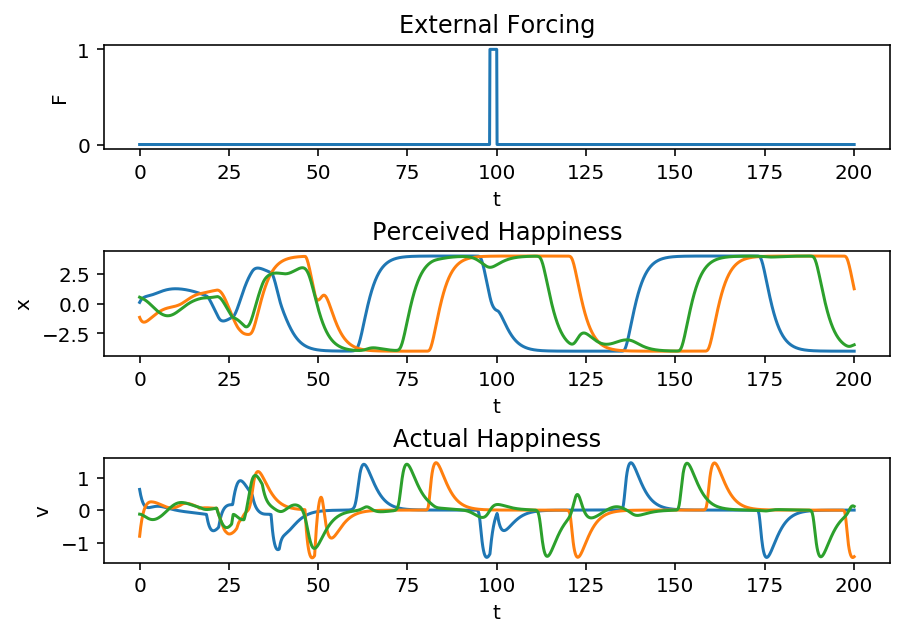

In [132]:
fig, axes = plt.subplots(3, 1)
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=3.0)

axes[0].plot(t, [F(ti) for ti in t])
axes[0].set_title('External Forcing')
axes[0].set_ylabel('F')
axes[0].set_xlabel('t')

axes[1].plot(t, x)
axes[1].set_title('Perceived Happiness')
axes[1].set_ylabel('x')
axes[1].set_xlabel('t')

axes[2].plot(t, v)
axes[2].set_title('Actual Happiness')
axes[2].set_ylabel('v')
axes[2].set_xlabel('t')

## Plot Wij vs time


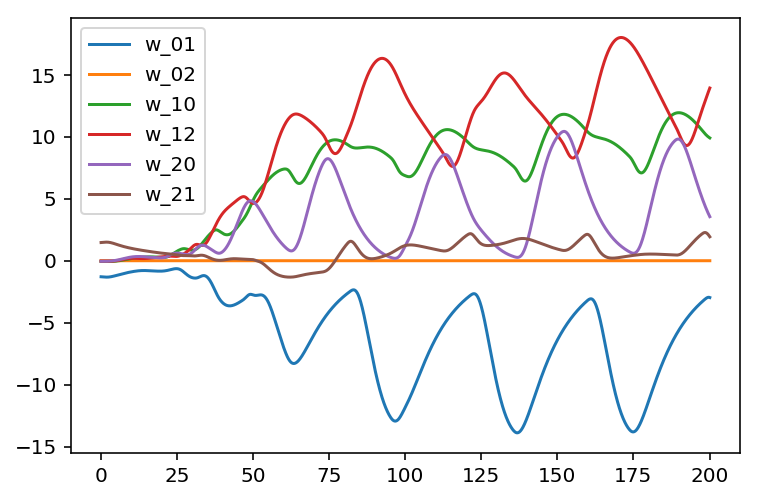

In [133]:
for i in range(min(N,3)):
    for j in range(min(N,3)):
        if i != j:
            plt.plot(t[1:], np.array(WIJ)[:, i, j], label = 'w_%s%s' %(i, j))
plt.legend()

# Animation

In [134]:
import networkx as nx

In [135]:
G=nx.from_numpy_matrix(Q) #boolean connectivity
pos=nx.spring_layout(G, weight=None)

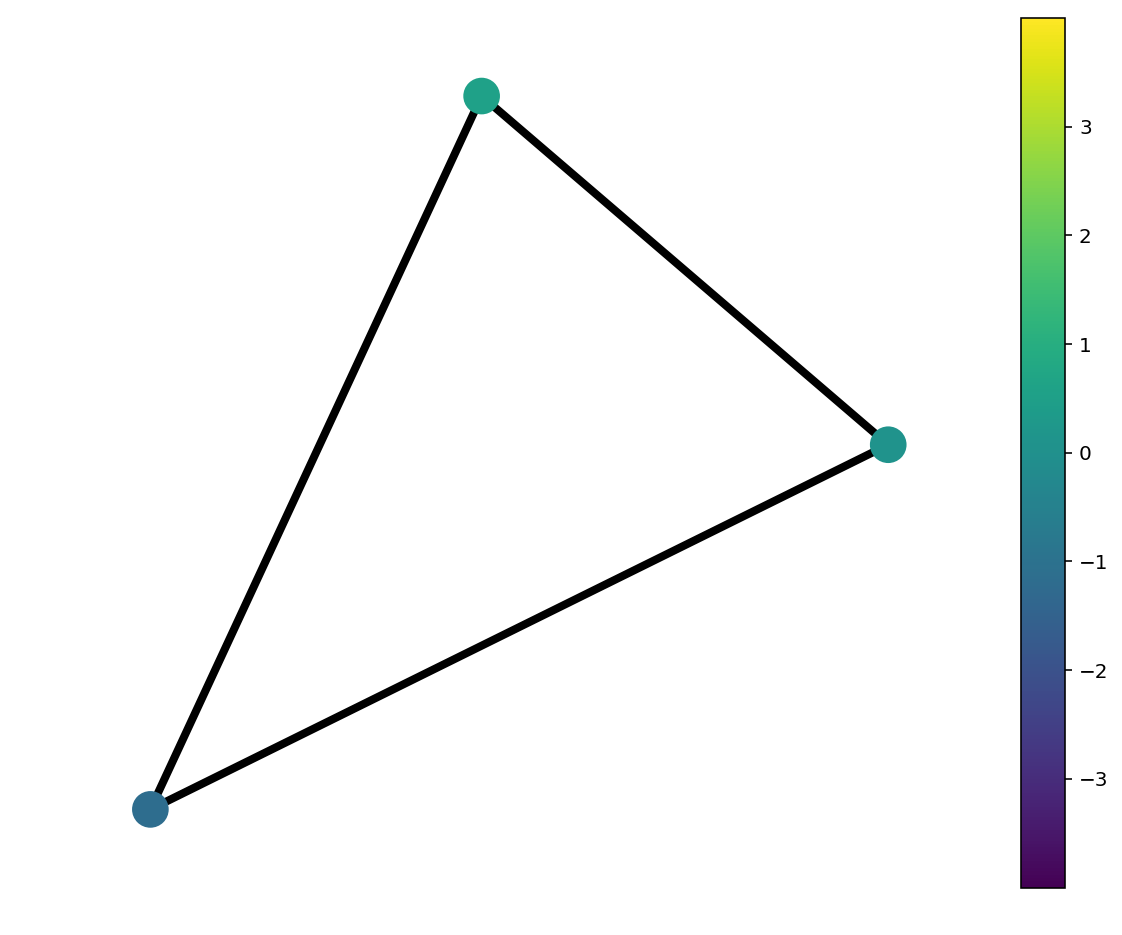

In [137]:
data = x 

# edge_colors = [g[2]["weight"] for g in G.edges(data=True)]
# edge_cmap=plt.cm.Blues

node_colors = data[0]
node_cmap = plt.cm.viridis
vmin = np.min(data)
vmax = np.max(data)
norm=plt.Normalize(vmin=vmin, vmax=vmax)

fig = plt.figure(figsize=(10,8))


nodes = nx.draw_networkx_nodes(
        G,pos,                        
        node_color=node_colors, node_cmap=node_cmap
    )

nx.draw_networkx_edges(
    G,pos,
    width=4,edge_cmap=edge_cmap #, edge_color=edge_colors
)
plt.axis('off')

sm = plt.cm.ScalarMappable(cmap=node_cmap, norm=norm)
sm._A = []
plt.colorbar(sm)

def update(i):
    node_colors = node_cmap(norm(data[i]))
    nodes.set_color(node_colors)
    
anim = animation.FuncAnimation(fig, update, frames = range(0, len(data), 2), interval=15)

anim